# Figure 1: SLF curves for base and fitted models

### Add paths to run locally or off NIRD

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


## Load data into metric classes

In [3]:
basemetric_slf = CT_SLF_Metric(case_dir)

basemetric_slf.add_case('20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1', label="CAM6-Oslo")
basemetric_slf.add_case('CESM2_slfvars', label="CAM6")
basemetric_slf.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1', label="CAM6-OsloIce")

Trying to load concatenated file for 20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for CESM2_slfvars


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
fitmetric_slf = CT_SLF_Metric(case_dir)

fitmetric_slf.add_case("20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10",label='CAM6-Oslo Fit 1')
fitmetric_slf.add_case('20200629_morn_cam61satcomp_wbf_0.5_inp_0.05',label='CAM6-OsloIce Fit 2')
# fitmetric_slf.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05',label='CAM6-OsloIce Fit 2')
fitmetric_slf.add_case('20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1',label='CAM6-OsloIce Fit 3')
# fitmetric_slf.add_case('CESM2_fittest',path='mnth15runs/')
fitmetric_slf.add_case('20200713_CESM2_satcomp_wbf_1_inp_100',label="CAM6 Fit 4")

Trying to load concatenated file for 20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200629_morn_cam61satcomp_wbf_0.5_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200713_CESM2_satcomp_wbf_1_inp_100


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
save_dict = {}

for _casename in fitmetric_slf.get_cases():
    case_da = fitmetric_slf.get_case(_casename).case_da
    slf_avg = masked_average(case_da['CT_SLF_TAVG'].sel(lat=slice(66,None)),weights=case_da['cell_weight'],dim=['lat','lon'])
    
    save_dict[_casename] = slf_avg.values
    
save_dict

{'20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10': array([0.04250966, 0.23480148, 0.4256196 , 0.69237163, 0.87304842,
        0.95069655, 0.98111462, 0.99748619, 0.99963161]),
 '20200629_morn_cam61satcomp_wbf_0.5_inp_0.05': array([0.06761018, 0.23086914, 0.43111904, 0.71213395, 0.8948271 ,
        0.94931466, 0.97981882, 0.99650482, 0.99952281]),
 '20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1': array([0.07890129, 0.2140922 , 0.36310172, 0.6049542 , 0.83005117,
        0.93234761, 0.97503273, 0.99527099, 0.99951321]),
 '20200713_CESM2_satcomp_wbf_1_inp_100': array([0.10462389, 0.2864696 , 0.52385554, 0.76175238, 0.91317224,
        0.94833993, 0.97674343, 0.99446217, 0.99938115])}

In [6]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

Unsuccessful attempt to use siunitx to do units :(

In [7]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots 
    "font.sans-serif": [],              # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts 
    "xtick.labelsize": 8,               # a little smaller
    "ytick.labelsize": 8,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts 
        r"\usepackage[T1]{fontenc}",        # plots will be generated
        r"\usepackage[detect-all,locale=DE]{siunitx}",
        ]                                   # using this preamble
    }
# }}}
mpl.rcParams.update(pgf_with_latex)

#     "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.85,0.8,'b.')

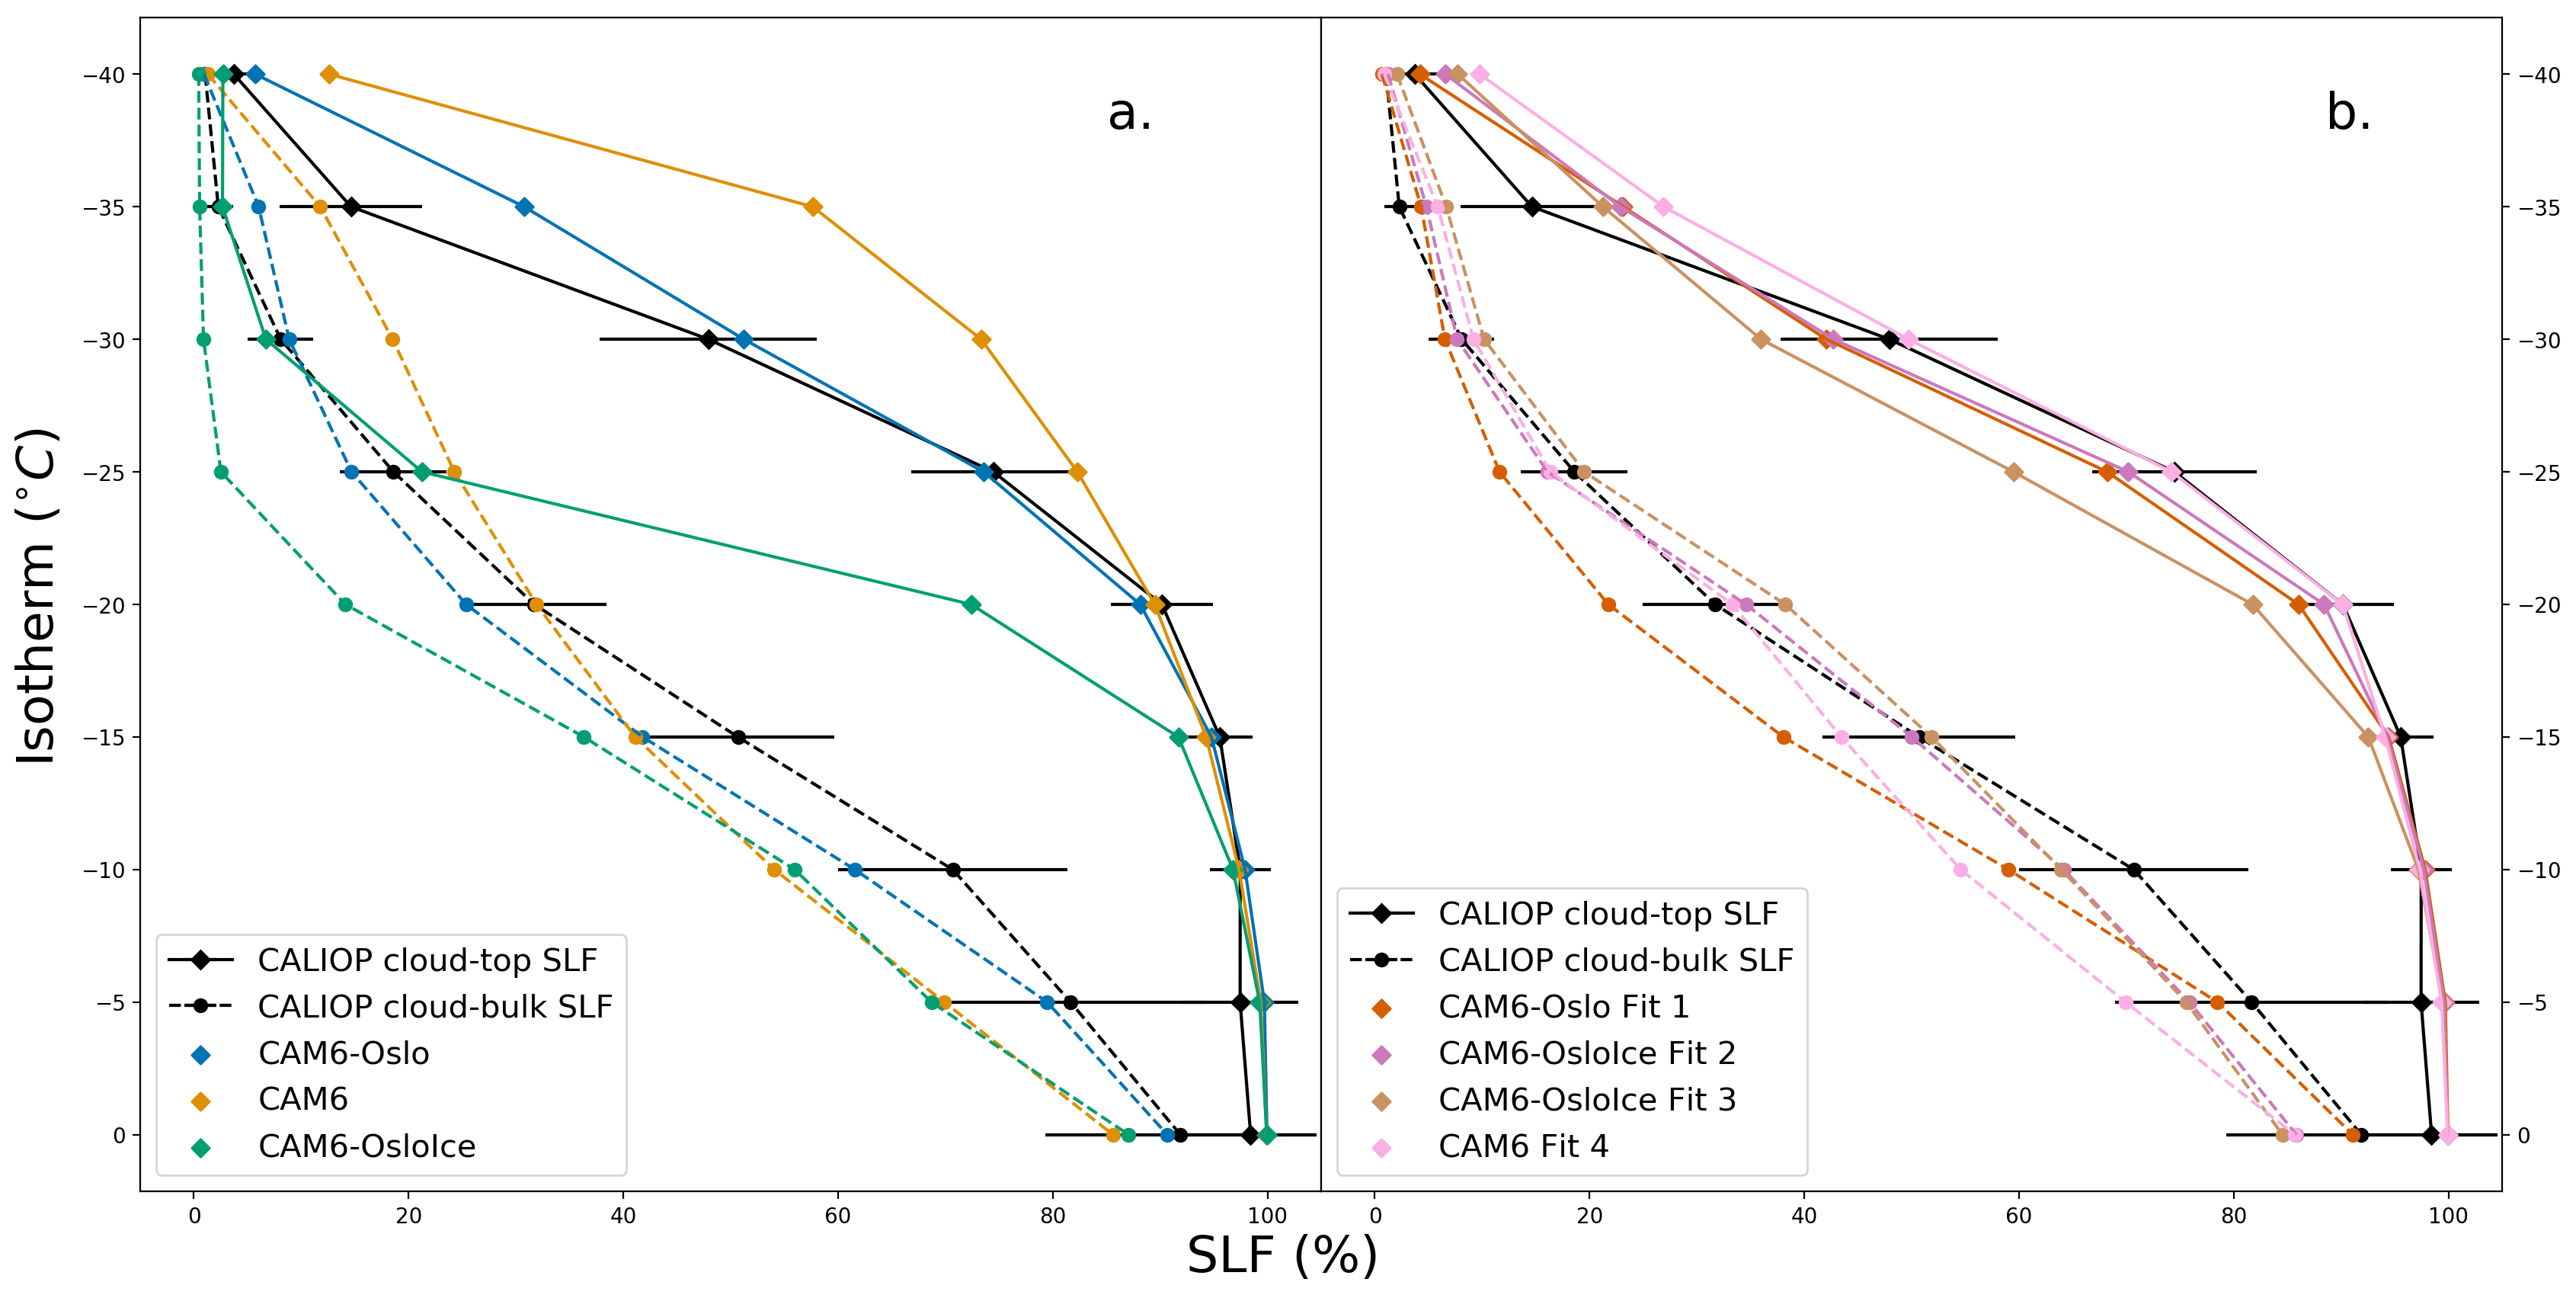

In [8]:
# Use different colors for the two subplots. Use the Seaborn colorblind palette (really pretty!)
plt.style.use('default')
basemetric_slf.colors = sns.color_palette("colorblind")[:3] 
fitmetric_slf.colors = sns.color_palette("colorblind")[3:]

fig,axs = plt.subplots(nrows=1,ncols=2)#,sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

# axs[0].invert_yaxis()
o = basemetric_slf.plot_isos_all(ax=axs[0])

# axs[1].invert_yaxis()
oo = fitmetric_slf.plot_isos_all(ax=axs[1])

fig.subplots_adjust(wspace=0.0)

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[0].set_title('')
axs[1].set_title('')
# axs[1].set_yticks(np.arange(-40,0,5),' ')
# axs[1].get_yaxis().set_ticks([])
axs[1].yaxis.tick_right()
# axs[1].set_yticklabels([])
# axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=15)
# axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=15)
# axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=15)
# axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=15)
# handles, labels = axs[1].get_legend_handles_labels()
# axs[1].legend(handles, labels, loc = 'lower left')

fig.text(0.1, 0.5, r'Isotherm ($^{\circ}C$)', va='bottom', ha='center', rotation='vertical', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.5, 0.05, 'SLF (%)', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

# fig.text(0.15, 0.2, 'a.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)
# fig.text(0.55, 0.2, 'b.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)

fig.text(0.45, 0.8, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.85, 0.8, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.85,0.8,'b.')

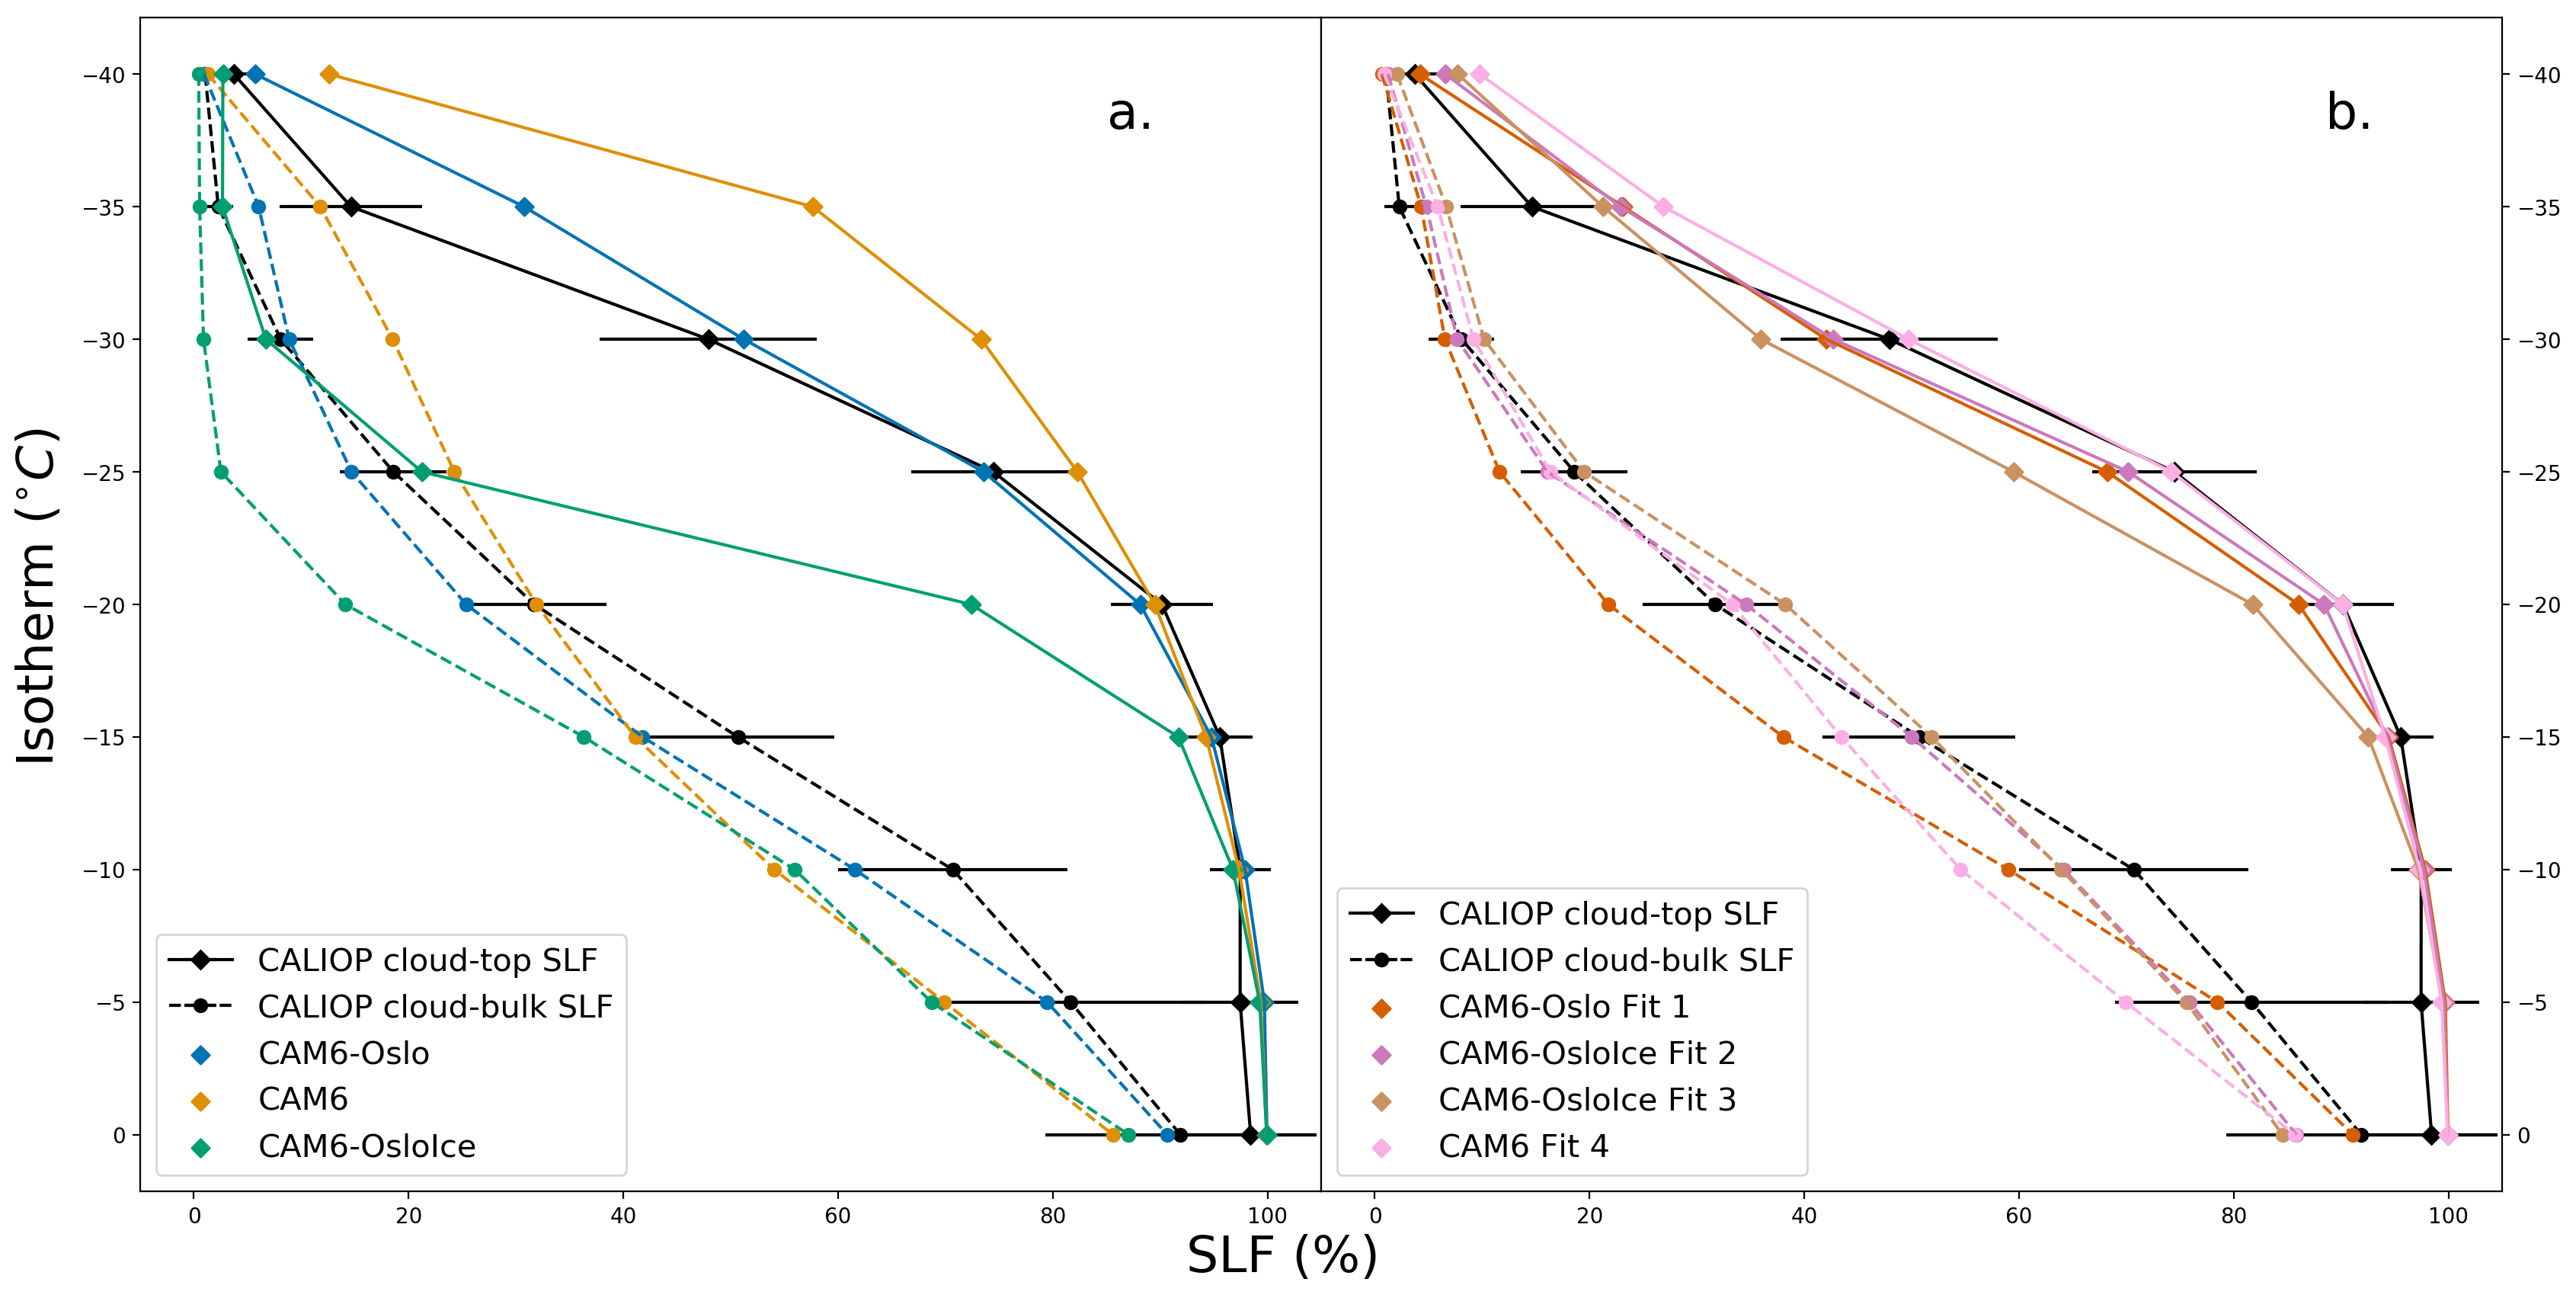

In [16]:
# Use different colors for the two subplots. Use the Seaborn colorblind palette (really pretty!)
plt.style.use('default')
basemetric_slf.colors = sns.color_palette("colorblind")[:3] 
fitmetric_slf.colors = sns.color_palette("colorblind")[3:]

fig,axs = plt.subplots(nrows=1,ncols=2)#,sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

# axs[0].invert_yaxis()
o = basemetric_slf.plot_isos_all(ax=axs[0])

# axs[1].invert_yaxis()
oo = fitmetric_slf.plot_isos_all(ax=axs[1])

fig.subplots_adjust(wspace=0.0)

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[0].set_title('')
axs[1].set_title('')
# axs[1].set_yticks(np.arange(-40,0,5),' ')
# axs[1].get_yaxis().set_ticks([])
axs[1].yaxis.tick_right()
# axs[1].set_yticklabels([])
# axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=15)
# axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=15)
# axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=15)
# axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=15)
# handles, labels = axs[1].get_legend_handles_labels()
# axs[1].legend(handles, labels, loc = 'lower left')

fig.text(0.1, 0.5, r'Isotherm ($^{\circ}C$)', va='bottom', ha='center', rotation='vertical', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.5, 0.05, 'SLF (%)', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

# fig.text(0.15, 0.2, 'a.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)
# fig.text(0.55, 0.2, 'b.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)

fig.text(0.45, 0.8, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.85, 0.8, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

In [17]:
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=15)
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=15)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=15)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=15)

[Text(1,-45,'−45'),
 Text(1,-40,'−40'),
 Text(1,-35,'−35'),
 Text(1,-30,'−30'),
 Text(1,-25,'−25'),
 Text(1,-20,'−20'),
 Text(1,-15,'−15'),
 Text(1,-10,'−10'),
 Text(1,-5,'−5'),
 Text(1,0,'0'),
 Text(1,5,'5')]

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.85,0.8,'b.')

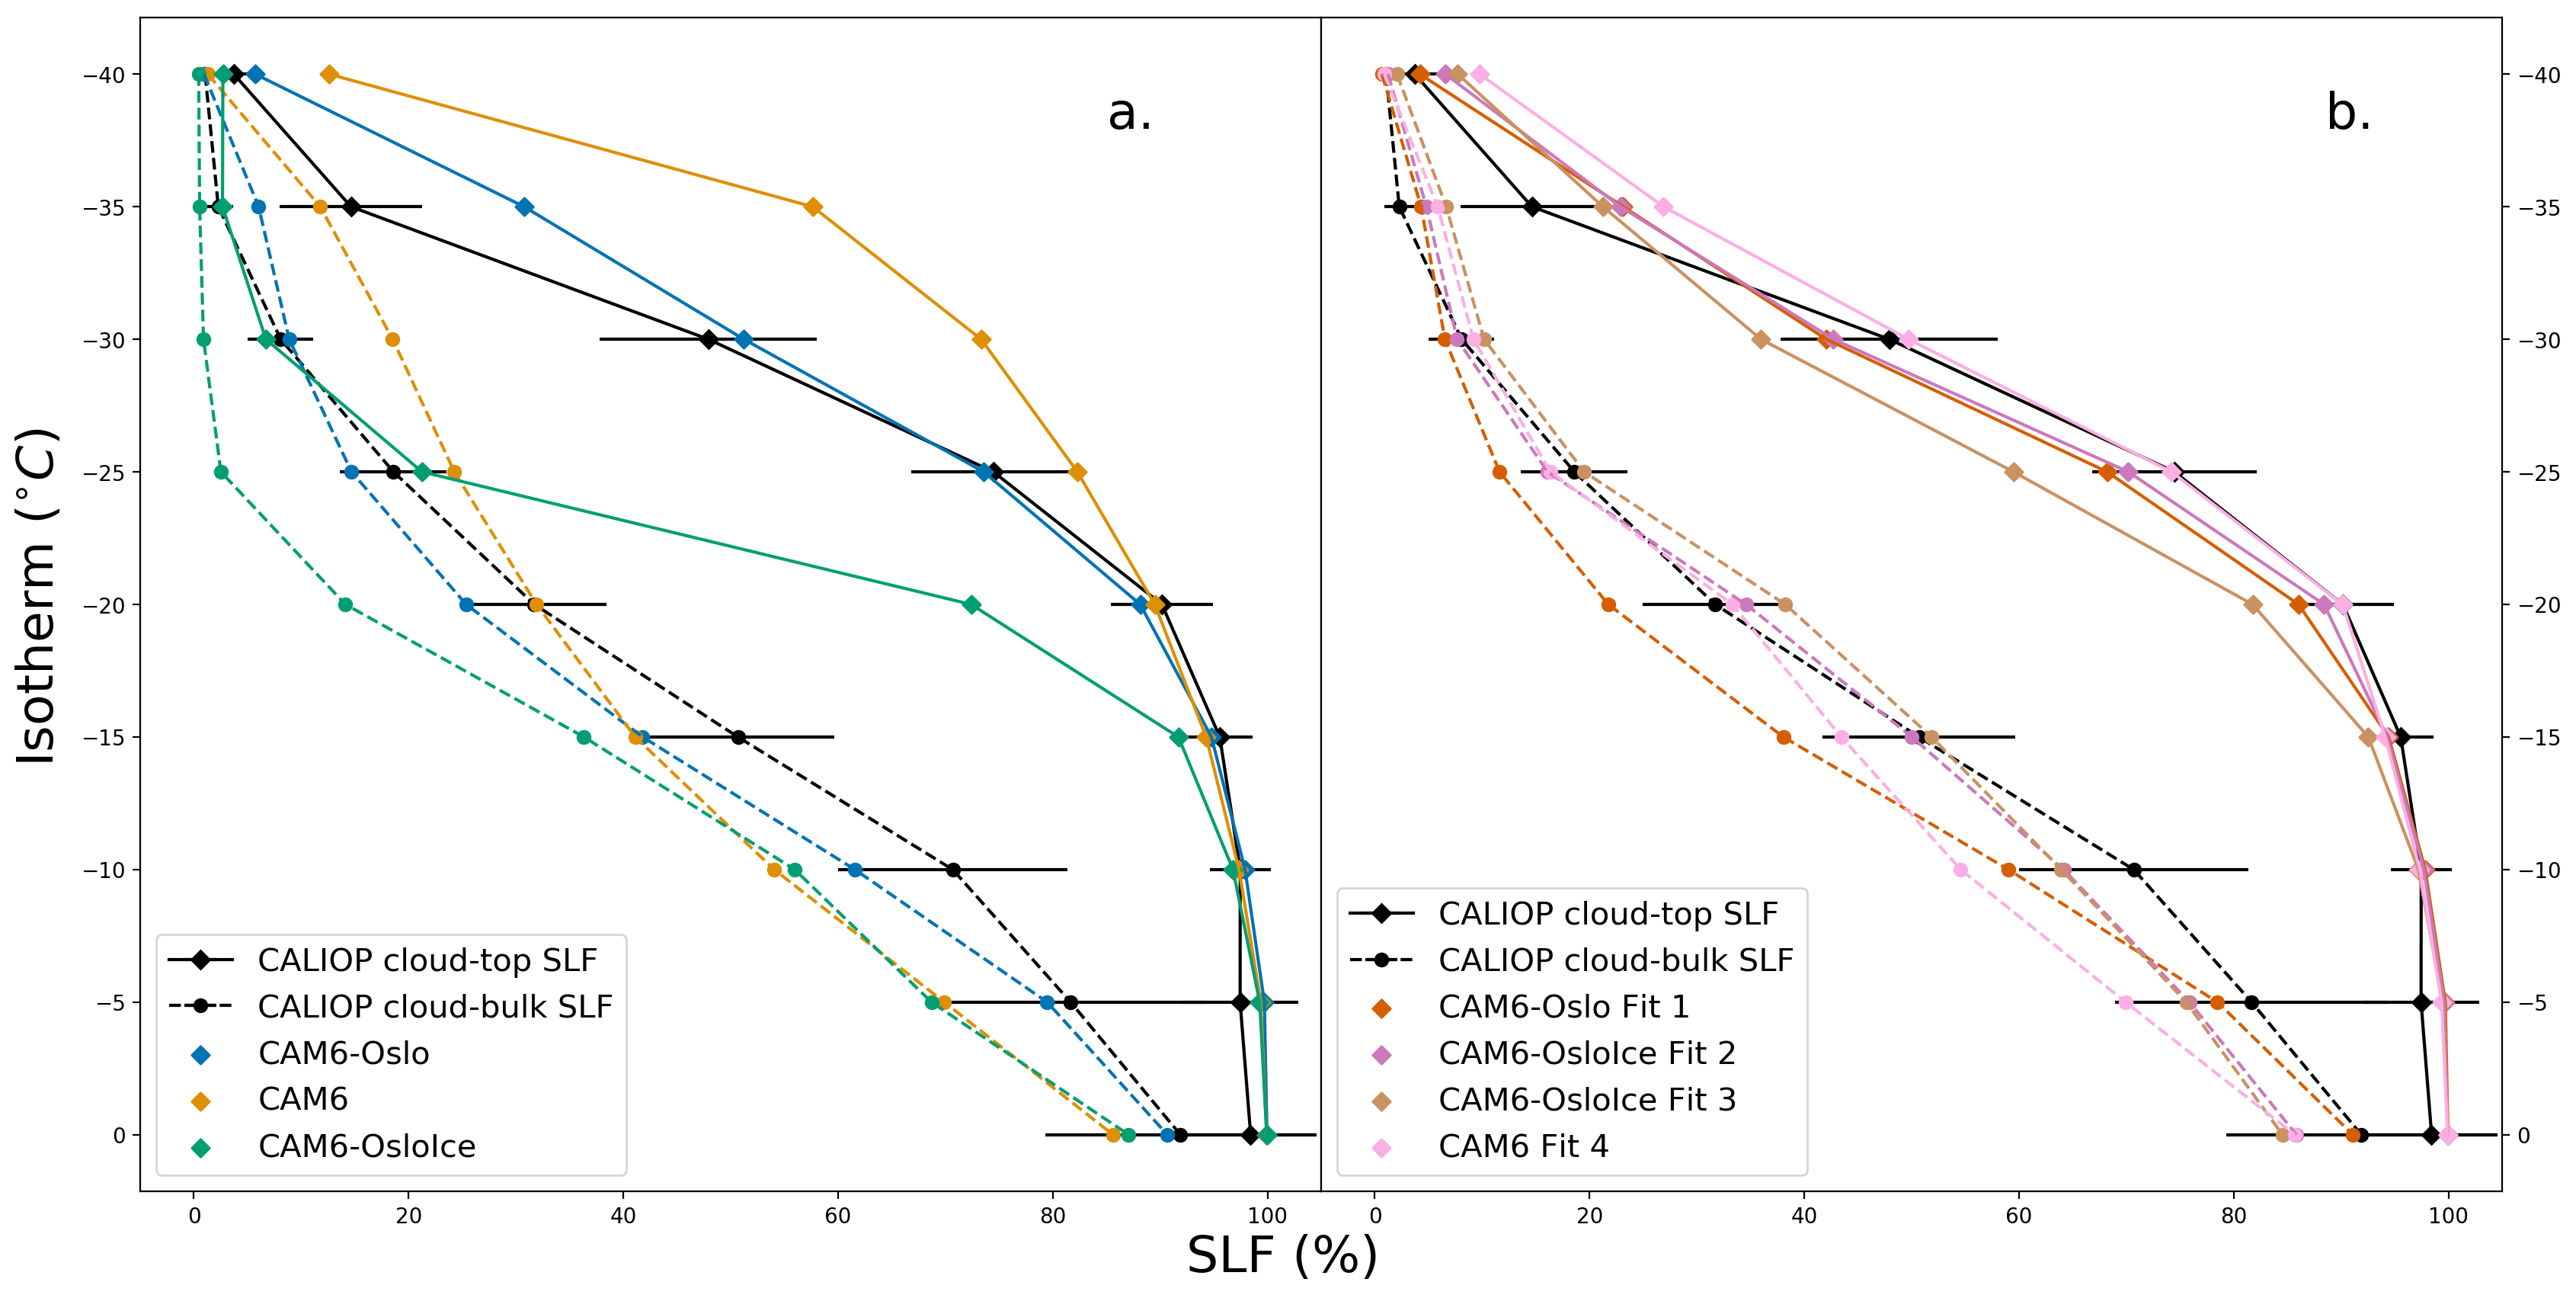

In [6]:
# Use different colors for the two subplots. Use the Seaborn colorblind palette (really pretty!)
plt.style.use('default')
basemetric_slf.colors = sns.color_palette("colorblind")[:3] 
fitmetric_slf.colors = sns.color_palette("colorblind")[3:]

fig,axs = plt.subplots(nrows=1,ncols=2)#,sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

# axs[0].invert_yaxis()
o = basemetric_slf.plot_isos_all(ax=axs[0])

# axs[1].invert_yaxis()
oo = fitmetric_slf.plot_isos_all(ax=axs[1])

fig.subplots_adjust(wspace=0.0)

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[0].set_title('')
axs[1].set_title('')
# axs[1].set_yticks(np.arange(-40,0,5),' ')
# axs[1].get_yaxis().set_ticks([])
axs[1].yaxis.tick_right()
# axs[1].set_yticklabels([])

# handles, labels = axs[1].get_legend_handles_labels()
# axs[1].legend(handles, labels, loc = 'lower left')

fig.text(0.1, 0.5, r'Isotherm ($^{\circ}C$)', va='bottom', ha='center', rotation='vertical', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.5, 0.05, 'SLF (%)', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

# fig.text(0.15, 0.2, 'a.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)
# fig.text(0.55, 0.2, 'b.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)

fig.text(0.45, 0.8, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.85, 0.8, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

In [19]:
to_png(fig,"combined_slfcurves_simp")